In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import statistics
import os
import random

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#torch dataset 
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, num_crops=1, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.num_crops = num_crops
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def filter_by_lens(data, size):
    return data[data["ICL Size"]==size]
def get_paths_and_labels(subjects, data, data_dir='AS-OCT data'):
    '''given a list of subject names, returns a list of corresponding file names and labels(vault sizes)'''
    def is_valid(file_path):
        for dir in subjects:
            if dir in file_path:
                return True
        return False
    paths = []
    labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file == "desktop.ini":
                continue
            file_path = os.path.join(root, file)
            if is_valid(file_path):
                label = data.loc[data['Subject (Eye)']== int(root.split('/')[-1].split(' ')[-1])]['Post-Op Vault']
                if not label.empty:
                    paths.append(file_path)
                    labels.append(label.values[0])
    return (paths, labels)
def evaluate_model(model, dataloader, criterion= nn.L1Loss(), device=device, show_val=False):
    '''evaluate model on specified dataset'''
    model.eval()  
    running_loss = 0.0
    with torch.no_grad(): 
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device).float()  
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            if show_val:
                print(f'predicted {outputs}, expected {labels}, loss {loss}')
            running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    print(f"Evaluation Loss: {avg_loss:.4f}")
def train_model(model, num_epochs, dataloader_train, dataloader_test, device=device, criterion = nn.L1Loss(), learning_rate=0.01):
    '''train model with specified datasets'''
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_avg = [] #average loss over all epochs 
    validation_loss_avg =[] 
    train_loss_std = [] #std of losses over all epochs
    validation_loss_std = []
    for epoch in range(num_epochs):
        train_loss = [] #inividual loss for a single epoch
        validation_loss = []
        model.train() 
        running_loss = 0.0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  
            #print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            running_loss += loss.item()
        lossT = running_loss/len(dataloader_train)
        train_loss_avg.append(lossT)
        train_loss_std.append(statistics.stdev(train_loss))
        #use testing set to validate for now 
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader_test:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                validation_loss.append(loss.item())
                running_val_loss += loss.item()
        lossV = running_val_loss / len(dataloader_test)
        validation_loss_avg.append(lossV)
        validation_loss_std.append(statistics.stdev(validation_loss))
        if lossT < lossV*0.8:
            print(f'training loss is less than validation loss, V{lossV}, T{lossT}')
        print(f"Epoch {epoch + 1}/{num_epochs}, Traning Loss: {lossT}, Validation loss: {lossV}")
    return (train_loss_avg, validation_loss_avg, train_loss_std, validation_loss_std)
def plot(train_loss, validation_loss, train_std, val_std, num_epochs, title):
    '''plot the train and validation graph with std'''
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.fill_between(epochs, np.array(train_loss) - np.array(train_std), np.array(train_loss) + np.array(train_std), color='blue', alpha=0.2)
    plt.plot(epochs, validation_loss, label='Validation Loss', color='orange')
    plt.fill_between(epochs, np.array(validation_loss) - np.array(val_std), np.array(validation_loss) + np.array(val_std), color='orange', alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title + " Training and Validation Loss Trends")
    plt.legend()
    last_epoch = num_epochs
    last_train_loss = train_loss[-1]
    last_val_loss = validation_loss[-1]
    last_val_std = val_std[-1]
    plt.annotate(f'Train Loss: {last_train_loss:.2f}', 
                 xy=(last_epoch, last_train_loss), 
                 xytext=(last_epoch, last_train_loss + 0.05),
                 arrowprops=dict(facecolor='blue', shrink=0.05),
                 fontsize=10, color='blue')
    
    plt.annotate(f'Validation Loss: {last_val_loss:.2f}', 
                 xy=(last_epoch, last_val_loss), 
                 xytext=(last_epoch, last_val_loss + 0.05),
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10, color='orange')
    plt.annotate(f'Validation Std: {last_val_std:.2f}', 
                 xy=(last_epoch, last_val_loss - last_val_std), 
                 xytext=(last_epoch, last_val_loss - last_val_std - 0.05),
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10, color='red')
    
    plt.show()
def construct_dataset_with_lens(data, lens, batch_size=2, test_size=0.15):
    '''construct training and validation dataset for specific lens'''
    if lens: 
        data = filter_by_lens(data, lens)
    train, test = train_test_split(data, test_size=test_size)
    subject_test = ["Subject "+str(num) for num in test['Subject (Eye)']]
    subject_train = ["Subject "+str(num) for num in train['Subject (Eye)']]
    train_path, train_labels = get_paths_and_labels(subject_train,data, data_dir='OCT_Data')
    test_path, test_labels = get_paths_and_labels(subject_test,data, data_dir='OCT_Data')
    #print('paths', test_path)
    dataset_train = ImageDataset(image_paths=train_path, labels=train_labels, transform=transform)
    dataset_test = ImageDataset(image_paths=test_path, labels=test_labels, transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    return dataloader_train, dataloader_test
def train_on_lens(model, data, lens=12.6, epoch=30, batch_size=2):
    print("-----constructing databases-----")
    if lens: 
        data = filter_by_lens(data, lens)
    train, test = train_test_split(data, test_size=0.15)
    subject_test = ["Subject "+str(num) for num in test['Subject (Eye)']]
    subject_train = ["Subject "+str(num) for num in train['Subject (Eye)']]
    train_path, train_labels = get_paths_and_labels(subject_train,data, data_dir='OCT_Data')
    test_path, test_labels = get_paths_and_labels(subject_test,data, data_dir='OCT_Data')
    dataset_train = ImageDataset(image_paths=train_path, labels=train_labels, transform=transform)
    dataset_test = ImageDataset(image_paths=test_path, labels=test_labels, transform=transform)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    print(f"complete. test size: {len(subject_test)}, train size: {len(subject_train)}")
    print("----training starts-----")
    train_loss_avg, validation_los_avg, train_loss_std, validation_loss_std = train_model(model, epoch, dataloader_train,dataloader_test, learning_rate=0.01)
    print("----training finishes-----")
    plot(train_loss_avg, validation_los_avg, train_loss_std, validation_loss_std, epoch, str(lens))
    evaluate_model(model, dataloader=dataloader_test, show_val=True)

In [8]:
data = pd.read_excel('OCT_Collated.xlsx')
data = data.loc[:, ['Subject (Eye)','ICL Size', 'Post-Op Vault']]
data = data[86:] #exclude the previous subjects. mark off if train on new model
data = data[-data['Post-Op Vault'].isna()]
data

,Subject (Eye),ICL Size,Post-Op Vault
86,87,12.6,525.0
87,88,12.6,413.0
88,89,12.6,672.0
89,90,12.6,646.0
90,91,12.1,333.0
...,...,...,...
458,459,13.2,592.0
459,460,12.6,554.0
460,461,12.6,618.0
461,462,12.6,538.0


-----constructing databases-----
complete. test size: 30, train size: 165
----training starts-----


/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/10, Traning Loss: 170.33259440830776, Validation loss: 162.59398365020752
Epoch 2/10, Traning Loss: 178.16769452776228, Validation loss: 149.1840000152588
Epoch 3/10, Traning Loss: 167.49011993408203, Validation loss: 174.51878690719604
Epoch 4/10, Traning Loss: 166.23073305402482, Validation loss: 144.04343938827515
Epoch 5/10, Traning Loss: 174.09595729282924, Validation loss: 143.62453079223633
Epoch 6/10, Traning Loss: 166.33159931727818, Validation loss: 142.27226734161377
Epoch 7/10, Traning Loss: 166.01566957746232, Validation loss: 163.23296880722046
Epoch 8/10, Traning Loss: 160.3102919442313, Validation loss: 188.55375051498413
Epoch 9/10, Traning Loss: 156.24948784964425, Validation loss: 165.25038957595825
Epoch 10/10, Traning Loss: 157.43626839773995, Validation loss: 154.30401372909546
----training finishes-----


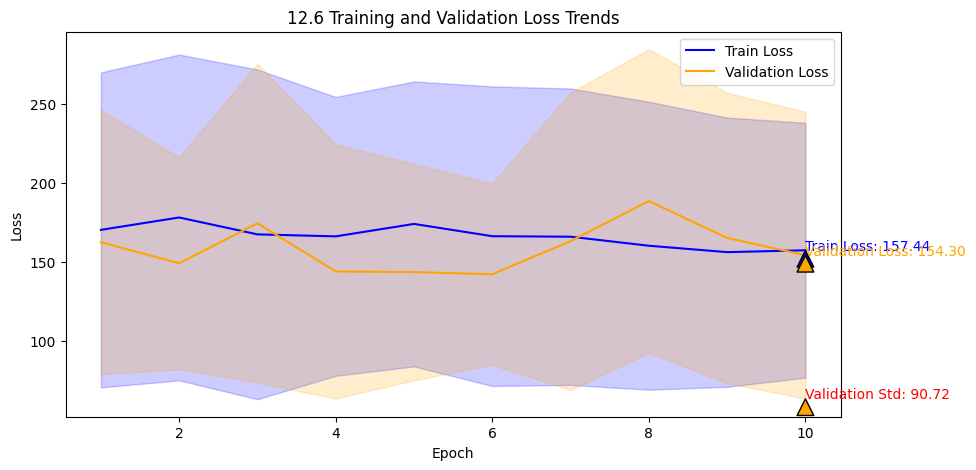

predicted tensor([524.5889, 470.3727]), expected tensor([799., 358.]), loss 193.39190673828125
predicted tensor([480.1524, 472.2884]), expected tensor([358., 794.]), loss 221.93203735351562
predicted tensor([451.9193, 442.0290]), expected tensor([515., 480.]), loss 50.52587890625
predicted tensor([390.2186, 436.1225]), expected tensor([806., 698.]), loss 338.8294677734375
predicted tensor([522.8145, 426.8704]), expected tensor([368., 691.]), loss 209.47206115722656
predicted tensor([565.8654, 464.6627]), expected tensor([518., 662.]), loss 122.60134887695312
predicted tensor([414.2498, 457.8813]), expected tensor([381., 483.]), loss 29.1842041015625
predicted tensor([475.2784, 517.5502]), expected tensor([435., 799.]), loss 160.86412048339844
predicted tensor([474.8382, 440.0991]), expected tensor([435., 314.]), loss 82.9686279296875
predicted tensor([432.2857, 560.1063]), expected tensor([566., 640.]), loss 106.80398559570312
predicted tensor([503.3286, 465.3397]), expected tensor([48

In [23]:
model = torch.load('trained_models/current_model')
train_on_lens(model, data, 12.6, 10, 2)

In [24]:
torch.save(model, 'trained_models/model12.6')

-----constructing databases-----
complete. test size: 8, train size: 39
----training starts-----
Epoch 1/10, Traning Loss: 159.001357869899, Validation loss: 155.6302252875434
training loss is less than validation loss, V220.11815388997397, T160.58566121852144
Epoch 2/10, Traning Loss: 160.58566121852144, Validation loss: 220.11815388997397
Epoch 3/10, Traning Loss: 169.052505168509, Validation loss: 194.7517547607422
Epoch 4/10, Traning Loss: 156.73089567143867, Validation loss: 139.98067728678384
Epoch 5/10, Traning Loss: 155.18798730728474, Validation loss: 133.67309061686197
training loss is less than validation loss, V216.4996100531684, T138.97568560661153
Epoch 6/10, Traning Loss: 138.97568560661153, Validation loss: 216.4996100531684
training loss is less than validation loss, V195.2377234564887, T151.7198306144552
Epoch 7/10, Traning Loss: 151.7198306144552, Validation loss: 195.2377234564887
Epoch 8/10, Traning Loss: 138.28473354907746, Validation loss: 150.80588107638889
Epoc

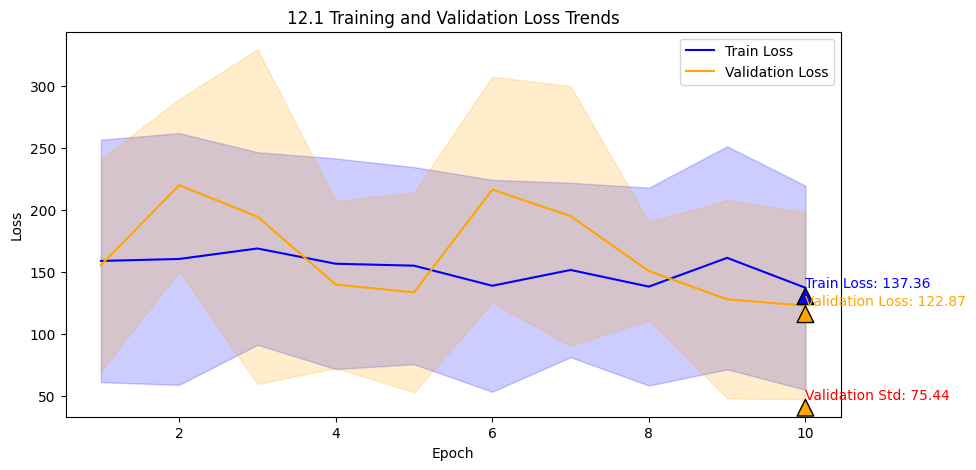

predicted tensor([369.3801, 369.3208]), expected tensor([454., 355.]), loss 49.47038269042969
predicted tensor([350.5652, 348.2540]), expected tensor([237., 637.]), loss 201.15560913085938
predicted tensor([337.0335, 360.5074]), expected tensor([237., 637.]), loss 188.2630615234375
predicted tensor([344.4822, 352.6381]), expected tensor([355., 346.]), loss 8.577957153320312
predicted tensor([342.0956, 364.7003]), expected tensor([454., 355.]), loss 60.802337646484375
predicted tensor([356.2195, 375.6723]), expected tensor([157., 237.]), loss 168.9459228515625
predicted tensor([311.2802, 359.3757]), expected tensor([637., 157.]), loss 264.04779052734375
predicted tensor([366.8924, 333.8703]), expected tensor([346., 346.]), loss 16.511077880859375
predicted tensor([342.3026, 343.2791]), expected tensor([157., 454.]), loss 148.01177978515625
Evaluation Loss: 122.8651


In [25]:
model = torch.load('trained_models/current_model')
train_on_lens(model, data, 12.1, 10, 2)

In [26]:
torch.save(model, 'trained_models/model12.1')

-----constructing databases-----
complete. test size: 20, train size: 107
----training starts-----
Epoch 1/15, Traning Loss: 206.4668930553999, Validation loss: 152.4153030395508
training loss is less than validation loss, V379.82767791748046, T191.17099774470094
Epoch 2/15, Traning Loss: 191.17099774470094, Validation loss: 379.82767791748046
Epoch 3/15, Traning Loss: 206.11397627533458, Validation loss: 150.33517150878907
Epoch 4/15, Traning Loss: 197.01466582251376, Validation loss: 152.24563293457032
Epoch 5/15, Traning Loss: 193.9400192010598, Validation loss: 181.60641555786134
Epoch 6/15, Traning Loss: 191.34323332739658, Validation loss: 190.10577545166015
Epoch 7/15, Traning Loss: 187.5799406708264, Validation loss: 163.5977294921875
training loss is less than validation loss, V290.7518707275391, T193.4461483564533
Epoch 8/15, Traning Loss: 193.4461483564533, Validation loss: 290.7518707275391
Epoch 9/15, Traning Loss: 194.35828074470896, Validation loss: 206.82897491455077
Ep

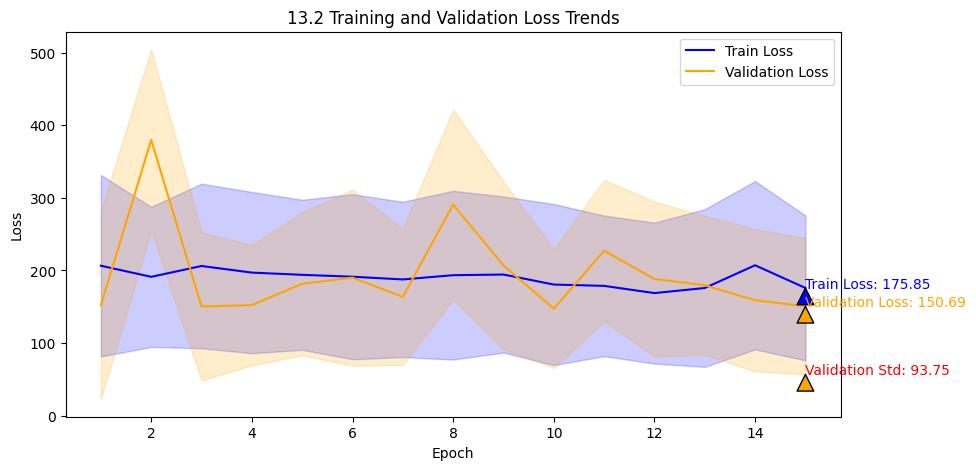

predicted tensor([570.8874, 543.5387]), expected tensor([429., 624.]), loss 111.17434692382812
predicted tensor([545.8903, 576.7654]), expected tensor([1094.,  630.]), loss 300.67218017578125
predicted tensor([578.3719, 551.4651]), expected tensor([723., 624.]), loss 108.58151245117188
predicted tensor([577.4287, 577.8317]), expected tensor([598., 435.]), loss 81.70147705078125
predicted tensor([541.4609, 571.6980]), expected tensor([1094.,  630.]), loss 305.4205627441406
predicted tensor([563.7433, 568.2512]), expected tensor([723., 723.]), loss 157.00277709960938
predicted tensor([568.0303, 575.3585]), expected tensor([669., 435.]), loss 120.66412353515625
predicted tensor([575.0244, 550.7659]), expected tensor([435., 435.]), loss 127.8951416015625
predicted tensor([576.0912, 542.5341]), expected tensor([435., 624.]), loss 111.27859497070312
predicted tensor([559.5638, 575.8876]), expected tensor([598., 336.]), loss 139.16189575195312
predicted tensor([553.4036, 553.9984]), expected 

In [27]:
model = torch.load('trained_models/current_model')
train_on_lens(model, data, 13.2, 15, 2)

In [28]:
torch.save(model, 'trained_models/model13.2')

In [3]:
#13.2
predicted = torch.tensor([
    [570.8874, 543.5387],
    [545.8903, 576.7654],
    [578.3719, 551.4651],
    [577.4287, 577.8317],
    [541.4609, 571.6980],
    [563.7433, 568.2512],
    [568.0303, 575.3585],
    [575.0244, 550.7659],
    [576.0912, 542.5341],
    [559.5638, 575.8876],
    [553.4036, 553.9984],
    [572.3860, 570.7966],
    [578.4552, 570.3134],
    [577.5797, 559.2914],
    [556.0715, 569.2271],
    [576.8635, 574.4913],
    [573.4725, 576.3340],
    [572.8705, 545.1199],
    [548.3606, 576.2391]
])

expected = torch.tensor([
    [429., 624.],
    [1094., 630.],
    [723., 624.],
    [598., 435.],
    [1094., 630.],
    [723., 723.],
    [669., 435.],
    [435., 435.],
    [435., 624.],
    [598., 336.],
    [429., 669.],
    [432., 336.],
    [643., 429.],
    [630., 432.],
    [598., 643.],
    [442., 643.],
    [336., 442.],
    [442., 1094.],
    [669., 435.]
])

# Calculate the differences
differences = torch.abs(predicted - expected)
# Count predictions within specified ranges
within_500 = torch.sum(differences < 500).item()
within_200 = torch.sum(differences < 200).item()
within_50 = torch.sum(differences < 50).item()
within_250 = torch.sum(differences < 250).item()
within_400 = torch.sum(differences < 400).item()
print(predicted.shape)
print(f'Predictions within 500: {within_500}')
print(f'Predictions within 200: {within_200}')
print(f'Predictions within 250: {within_250}') #92%
print(f'Predictions within 400: {within_400}')
print(f'Predictions within 50: {within_50}')


torch.Size([19, 2])
Predictions within 500: 35
Predictions within 200: 32
Predictions within 250: 35
Predictions within 400: 35
Predictions within 50: 3


In [4]:
#12.1
predicted = torch.tensor([
    [369.3801, 369.3208],
    [350.5652, 348.2540],
    [337.0335, 360.5074],
    [344.4822, 352.6381],
    [342.0956, 364.7003],
    [356.2195, 375.6723],
    [311.2802, 359.3757],
    [366.8924, 333.8703],
    [342.3026, 343.2791]
])

expected = torch.tensor([
    [454., 355.],
    [237., 637.],
    [237., 637.],
    [355., 346.],
    [454., 355.],
    [157., 237.],
    [637., 157.],
    [346., 346.],
    [157., 454.]
])


differences = torch.abs(predicted - expected)


within_500 = torch.sum(differences < 500).item()
within_200 = torch.sum(differences < 200).item()
within_50 = torch.sum(differences < 50).item()
print(predicted.shape)
print(f'Predictions within 500: {within_500}')
print(f'Predictions within 200: {within_200}')
print(f'Predictions within 50: {within_50}')
within_250 = torch.sum(differences < 250).item()
within_400 = torch.sum(differences < 400).item()
print(f'Predictions within 250: {within_250}') #92%
print(f'Predictions within 400: {within_400}')


torch.Size([9, 2])
Predictions within 500: 18
Predictions within 200: 14
Predictions within 50: 6
Predictions within 250: 15
Predictions within 400: 18


In [5]:
#12.6
predicted = torch.tensor([
    [524.5889, 470.3727],
    [480.1524, 472.2884],
    [451.9193, 442.0290],
    [390.2186, 436.1225],
    [522.8145, 426.8704],
    [565.8654, 464.6627],
    [414.2498, 457.8813],
    [475.2784, 517.5502],
    [474.8382, 440.0991],
    [432.2857, 560.1063],
    [503.3286, 465.3397],
    [399.5899, 451.0208],
    [492.4405, 416.6567],
    [496.5539, 506.6384],
    [416.5565, 406.6457],
    [392.8054, 464.5107],
    [425.1316, 501.0078],
    [425.7101, 451.7088],
    [415.5873, 485.6874],
    [446.5662, 396.4631],
    [395.2803, 407.3357],
    [440.0579, 551.5078],
    [541.4025, 382.9446],
    [534.5544, 442.7856],
    [480.7505, 450.6339],
    [405.4615, 536.8889],
    [498.5820, 422.7031],
    [405.5655, 451.8766],
    [465.5029, 501.0631],
    [449.3203, 483.5875],
    [450.5565, 454.1103],
])

expected = torch.tensor([
    [799., 358.],
    [358., 794.],
    [515., 480.],
    [806., 698.],
    [368., 691.],
    [518., 662.],
    [381., 483.],
    [435., 799.],
    [435., 314.],
    [566., 640.],
    [480., 541.],
    [806., 640.],
    [662., 448.],
    [480., 490.],
    [381., 314.],
    [483., 515.],
    [435., 640.],
    [566., 662.],
    [381., 794.],
    [794., 858.],
    [858., 806.],
    [314., 518.],
    [490., 691.],
    [490., 698.],
    [515., 518.],
    [858., 358.],
    [691., 483.],
    [698., 448.],
    [448., 368.],
    [799., 541.],
    [566., 541.],
])

#149

# Calculate the differences
differences = torch.abs(predicted - expected)

# Count predictions within specified ranges
within_500 = torch.sum(differences < 500).item()
within_200 = torch.sum(differences < 200).item()
within_50 = torch.sum(differences < 50).item()
print(predicted.shape)
print(f'Predictions within 500: {within_500}')
print(f'Predictions within 200: {within_200}')
print(f'Predictions within 50: {within_50}')
within_250 = torch.sum(differences < 250).item()
within_400 = torch.sum(differences < 400).item()
print(f'Predictions within 250: {within_250}') 
print(f'Predictions within 400: {within_400}')

torch.Size([31, 2])
Predictions within 500: 62
Predictions within 200: 44
Predictions within 50: 18
Predictions within 250: 45
Predictions within 400: 57


In [34]:
# new model 
model = models.resnet50(pretrained=True)
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
#add a dropout layer and a linear layer (the expected output format is a single number)
num_in = model.fc.out_features
model.fc = nn.Sequential(model.fc, nn.Dropout(0.8), nn.Linear(in_features = num_in, out_features = 1, bias = True))
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
model

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

-----constructing databases-----
complete. test size: 30, train size: 165
----training starts-----


/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/30, Traning Loss: 209.57968717302595, Validation loss: 189.95301818847656
Epoch 2/30, Traning Loss: 184.68757749285018, Validation loss: 145.67903995513916
Epoch 3/30, Traning Loss: 177.13105130876815, Validation loss: 115.50351572036743
training loss is less than validation loss, V326.7395701408386, T180.846114894322
Epoch 4/30, Traning Loss: 180.846114894322, Validation loss: 326.7395701408386
Epoch 5/30, Traning Loss: 175.85096130371093, Validation loss: 113.13894939422607
training loss is less than validation loss, V786.598445892334, T174.56091232299804
Epoch 6/30, Traning Loss: 174.56091232299804, Validation loss: 786.598445892334
Epoch 7/30, Traning Loss: 163.6844737461635, Validation loss: 121.7360577583313
Epoch 8/30, Traning Loss: 178.76985506330217, Validation loss: 121.06215000152588
Epoch 9/30, Traning Loss: 167.58460039411273, Validation loss: 124.97888708114624
Epoch 10/30, Traning Loss: 171.33565303257532, Validation loss: 126.95989608764648
Epoch 11/30, Traning 

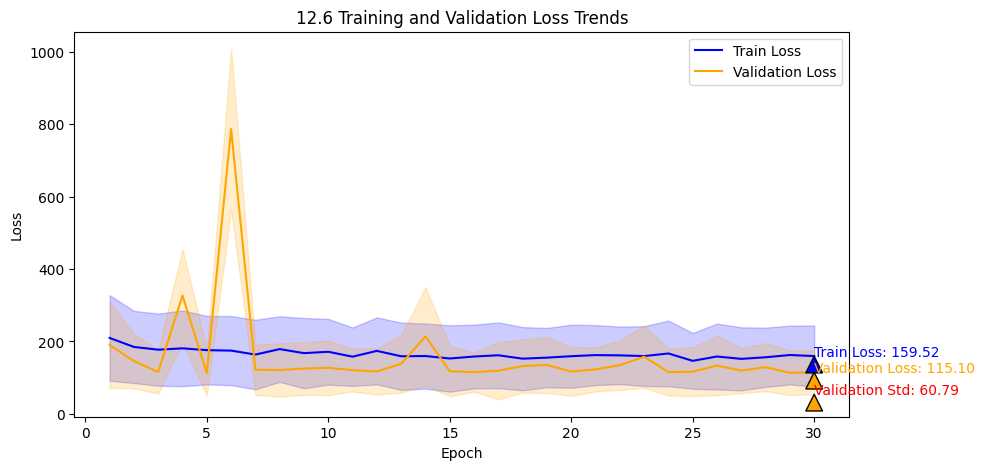

predicted tensor([507.1696, 519.9818]), expected tensor([794., 384.]), loss 211.40611267089844
predicted tensor([513.9279, 498.6975]), expected tensor([240., 499.]), loss 137.11521911621094
predicted tensor([524.2167, 519.8213]), expected tensor([518., 594.]), loss 40.197723388671875
predicted tensor([506.8577, 506.5640]), expected tensor([499., 336.]), loss 89.21084594726562
predicted tensor([490.2977, 491.0519]), expected tensor([576., 278.]), loss 149.3770751953125
predicted tensor([505.3967, 484.3074]), expected tensor([448., 576.]), loss 74.54461669921875
predicted tensor([514.8031, 506.1142]), expected tensor([518., 387.]), loss 61.15556335449219
predicted tensor([516.1055, 505.7273]), expected tensor([594., 448.]), loss 67.8109130859375
predicted tensor([508.3264, 514.5103]), expected tensor([538., 662.]), loss 88.58169555664062
predicted tensor([491.9213, 524.0555]), expected tensor([515., 662.]), loss 80.51156616210938
predicted tensor([515.9865, 502.9399]), expected tensor([5

In [35]:
train_on_lens(model, data, 12.6, 30, 2)

In [36]:
torch.save(model, 'trained_models/base12.6')

-----constructing databases-----
complete. test size: 8, train size: 39
----training starts-----


/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


training loss is less than validation loss, V1567.3258870442708, T244.40552407122672
Epoch 1/30, Traning Loss: 244.40552407122672, Validation loss: 1567.3258870442708
Epoch 2/30, Traning Loss: 183.82416096139463, Validation loss: 166.21080780029297
training loss is less than validation loss, V207.8667755126953, T153.73312556489984
Epoch 3/30, Traning Loss: 153.73312556489984, Validation loss: 207.8667755126953
Epoch 4/30, Traning Loss: 163.18946156603224, Validation loss: 130.79099867078992
training loss is less than validation loss, V1826.5759819878472, T189.1725187910364
Epoch 5/30, Traning Loss: 189.1725187910364, Validation loss: 1826.5759819878472
training loss is less than validation loss, V498.80284627278644, T176.14598765271776
Epoch 6/30, Traning Loss: 176.14598765271776, Validation loss: 498.80284627278644
Epoch 7/30, Traning Loss: 148.46469522029795, Validation loss: 127.43021477593317
Epoch 8/30, Traning Loss: 167.9181723087392, Validation loss: 131.78856913248697
Epoch 9/3

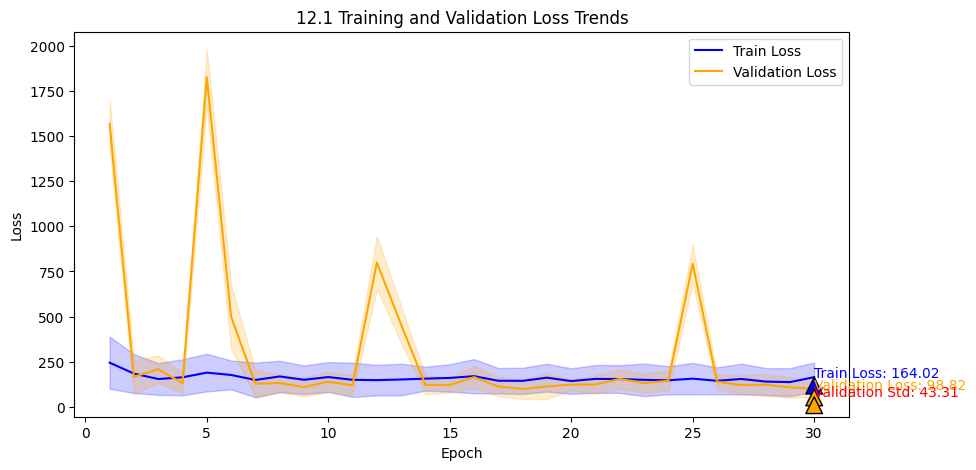

predicted tensor([342.1923, 332.1486]), expected tensor([157., 333.]), loss 93.02183532714844
predicted tensor([342.9772, 330.6056]), expected tensor([550., 157.]), loss 190.31417846679688
predicted tensor([332.4222, 349.1176]), expected tensor([195., 550.]), loss 169.15231323242188
predicted tensor([365.1786, 404.0409]), expected tensor([346., 458.]), loss 36.56884765625
predicted tensor([449.9863, 336.0603]), expected tensor([458., 195.]), loss 74.53701782226562
predicted tensor([349.9317, 334.2844]), expected tensor([550., 157.]), loss 188.6763458251953
predicted tensor([394.1036, 333.7515]), expected tensor([458., 333.]), loss 32.323974609375
predicted tensor([326.7662, 366.1239]), expected tensor([346., 346.]), loss 19.678863525390625
predicted tensor([373.8328, 324.3337]), expected tensor([333., 195.]), loss 85.08328247070312
Evaluation Loss: 98.8174


In [38]:
model = models.resnet50(pretrained=True)
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
#add a dropout layer and a linear layer (the expected output format is a single number)
num_in = model.fc.out_features
model.fc = nn.Sequential(model.fc, nn.Dropout(0.8), nn.Linear(in_features = num_in, out_features = 1, bias = True))
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
train_on_lens(model, data, 12.1, 30, 2)

-----constructing databases-----
complete. test size: 20, train size: 107
----training starts-----
Epoch 1/10, Traning Loss: 252.34882404765145, Validation loss: 276.1145263671875
Epoch 2/10, Traning Loss: 207.2484639902584, Validation loss: 188.98187408447265
Epoch 3/10, Traning Loss: 193.79503806692654, Validation loss: 198.9978515625
Epoch 4/10, Traning Loss: 183.54345265372854, Validation loss: 164.8584945678711
Epoch 5/10, Traning Loss: 181.46060493344166, Validation loss: 173.2775680541992
Epoch 6/10, Traning Loss: 194.33942113157178, Validation loss: 198.82652893066407
Epoch 7/10, Traning Loss: 184.83416785568488, Validation loss: 219.84880294799805
Epoch 8/10, Traning Loss: 184.58465676229508, Validation loss: 221.90199584960936
training loss is less than validation loss, V237.99620819091797, T182.3817388815958
Epoch 9/10, Traning Loss: 182.3817388815958, Validation loss: 237.99620819091797
Epoch 10/10, Traning Loss: 177.8909089135342, Validation loss: 172.12594146728514
----tr

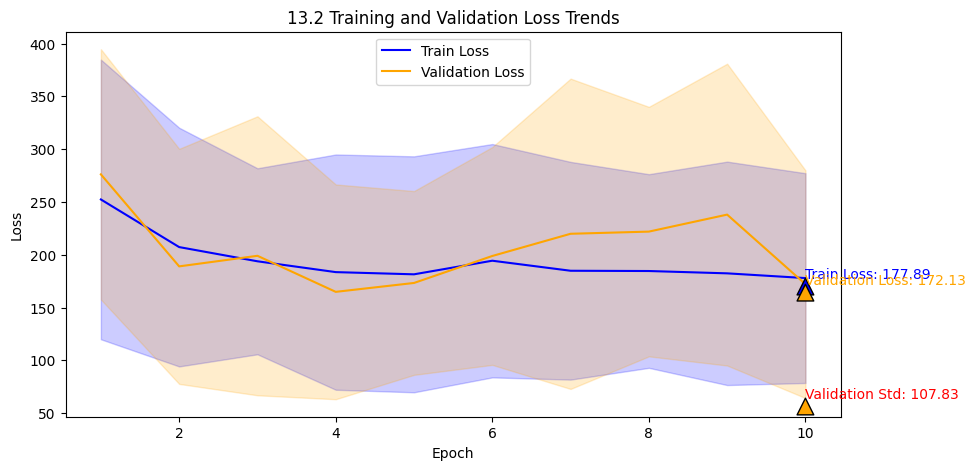

predicted tensor([719.3572, 703.4249]), expected tensor([336., 784.]), loss 231.96612548828125
predicted tensor([698.1365, 697.5585]), expected tensor([518., 621.]), loss 128.34747314453125
predicted tensor([695.5941, 694.2100]), expected tensor([1043.,  784.]), loss 218.59796142578125
predicted tensor([695.5481, 704.1622]), expected tensor([723., 621.]), loss 55.30706787109375
predicted tensor([702.2793, 705.6812]), expected tensor([826., 723.]), loss 70.519775390625
predicted tensor([700.5848, 707.7245]), expected tensor([518., 406.]), loss 242.1546630859375
predicted tensor([732.3630, 712.4764]), expected tensor([1043.,  406.]), loss 308.55670166015625
predicted tensor([712.4177, 710.6100]), expected tensor([570., 826.]), loss 128.90386962890625
predicted tensor([696.6544, 692.2268]), expected tensor([624., 336.]), loss 214.44061279296875
predicted tensor([704.6708, 695.5049]), expected tensor([1107., 1107.]), loss 406.91217041015625
predicted tensor([706.3948, 734.9304]), expected 

In [41]:
model = models.resnet50(pretrained=True)
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
#add a dropout layer and a linear layer (the expected output format is a single number)
num_in = model.fc.out_features
model.fc = nn.Sequential(model.fc, nn.Dropout(0.8), nn.Linear(in_features = num_in, out_features = 1, bias = True))
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
train_on_lens(model, data, 13.2, 10, 2)

In [61]:
#test on training on all lens instead of individual lens
data = pd.read_excel('OCT_Collated.xlsx')
data = data.loc[:, ['Subject (Eye)','ICL Size', 'Post-Op Vault']]
data = data[-data['Post-Op Vault'].isna()]
#take a bunch of data from each lens for testing 
data_126 = data.loc[data['ICL Size']==12.6][:30] #those are the test data
data_132 = data.loc[data['ICL Size']==13.2][:20]
data_121 = data.loc[data['ICL Size']==12.1][:8]
data = data.drop(data_126.index) #exclude from the trainning/val data 
data = data.drop(data_132.index)
data = data.drop(data_121.index)
model = models.resnet50(pretrained=True) #default resnet model 
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
num_in = model.fc.out_features
model.fc = nn.Sequential(model.fc, nn.Dropout(0.8), nn.Linear(in_features = num_in, out_features = 1, bias = True))
data_train, data_val = construct_dataset_with_lens(data, lens=12.6, batch_size=2,test_size=0.01)
train_126, test_126 = construct_dataset_with_lens(data_126, lens=12.6, batch_size=2, test_size=0.94)
print(len(data_train), len(test_126))

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


list 3 207
list content ['Subject 210', 'Subject 66', 'Subject 65']
paths ['OCT_Data/Subject 66/66-355.png', 'OCT_Data/Subject 66/66-0.png', 'OCT_Data/Subject 66/66-5.png', 'OCT_Data/Subject 65/65-355.png', 'OCT_Data/Subject 65/65-0.png', 'OCT_Data/Subject 65/65-5.png', 'OCT_Data/Subject 210/OD Bell 101.png', 'OCT_Data/Subject 210/OD Bell 100.png', 'OCT_Data/Subject 210/OD Bell 102.png']
list 29 1
list content ['Subject 25', 'Subject 2', 'Subject 17', 'Subject 56', 'Subject 16', 'Subject 49', 'Subject 28', 'Subject 46', 'Subject 50', 'Subject 1', 'Subject 7', 'Subject 29', 'Subject 39', 'Subject 6', 'Subject 43', 'Subject 18', 'Subject 34', 'Subject 40', 'Subject 59', 'Subject 11', 'Subject 26', 'Subject 8', 'Subject 5', 'Subject 33', 'Subject 45', 'Subject 12', 'Subject 27', 'Subject 30', 'Subject 55']
paths ['OCT_Data/Subject 5/5-355.png', 'OCT_Data/Subject 5/5-5.png', 'OCT_Data/Subject 5/5-0.png', 'OCT_Data/Subject 2/2-0.png', 'OCT_Data/Subject 2/2-5.png', 'OCT_Data/Subject 2/2-355.

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/30, Traning Loss: 213.4697562727348, Validation loss: 189.76271403919566
training loss is less than validation loss, V12890.204212535511, T190.76591596653853
Epoch 2/30, Traning Loss: 190.76591596653853, Validation loss: 12890.204212535511
training loss is less than validation loss, V1186.4162836941805, T181.4810879823392
Epoch 3/30, Traning Loss: 181.4810879823392, Validation loss: 1186.4162836941805
training loss is less than validation loss, V1284.5936730124733, T176.83764333573598
Epoch 4/30, Traning Loss: 176.83764333573598, Validation loss: 1284.5936730124733
Epoch 5/30, Traning Loss: 166.65476844424293, Validation loss: 185.53626043146306
training loss is less than validation loss, V249.1672959761186, T176.07964926421957
Epoch 6/30, Traning Loss: 176.07964926421957, Validation loss: 249.1672959761186
Epoch 7/30, Traning Loss: 170.99639819917223, Validation loss: 209.66239096901634
training loss is less than validation loss, V288.3809148615057, T166.5848940087374
Epoch 8/

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


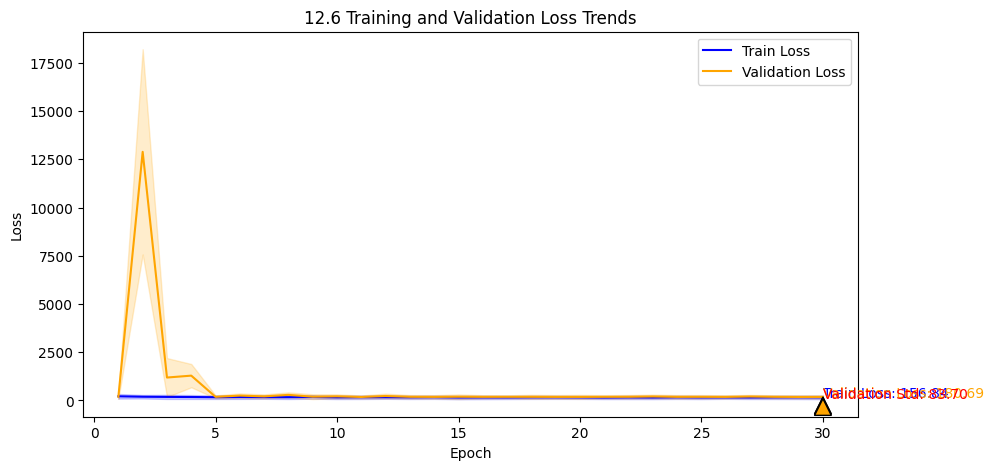

Evaluation Loss: 180.5402


In [62]:
train_loss_avg, validation_los_avg, train_loss_std, validation_loss_std= train_model(model, 30, data_train, test_126)
plot(train_loss_avg, validation_los_avg, train_loss_std, validation_loss_std, 30, "12.6")
evaluate_model(model, test_126)

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-----constructing databases-----
complete. test size: 36, train size: 204
----training starts-----


/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/30, Traning Loss: 226.5504322464848, Validation loss: 208.82697197698778
Epoch 2/30, Traning Loss: 196.91082928810286, Validation loss: 148.49371928553427
Epoch 3/30, Traning Loss: 194.0018434730959, Validation loss: 199.3733623873803
Epoch 4/30, Traning Loss: 175.50990440731957, Validation loss: 147.27865428309286
Epoch 5/30, Traning Loss: 186.89376381878213, Validation loss: 148.37747536936115
Epoch 6/30, Traning Loss: 181.6961805335371, Validation loss: 204.74950138215095
Epoch 7/30, Traning Loss: 176.43511487292005, Validation loss: 185.4098427064957
training loss is less than validation loss, V242.92842495825982, T175.3609928279728
Epoch 8/30, Traning Loss: 175.3609928279728, Validation loss: 242.92842495825982
Epoch 9/30, Traning Loss: 173.63733306488433, Validation loss: 149.0968317831716
Epoch 10/30, Traning Loss: 172.4152330671038, Validation loss: 181.07759881788684
Epoch 11/30, Traning Loss: 168.55768885756984, Validation loss: 181.86319363501764
Epoch 12/30, Traning

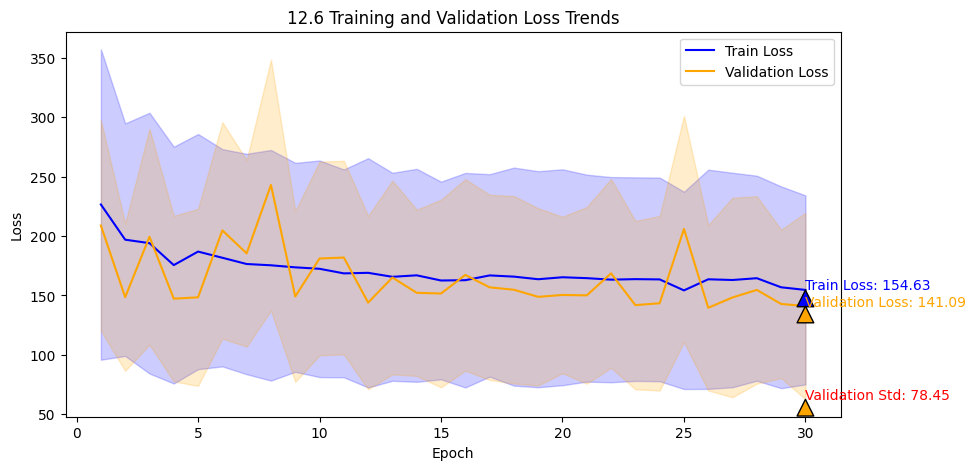

predicted tensor([539.5266, 593.9062]), expected tensor([627., 595.]), loss 44.2835693359375
predicted tensor([557.8965, 583.4188]), expected tensor([858., 858.]), loss 287.3423156738281
predicted tensor([576.7637, 572.3253]), expected tensor([314., 586.]), loss 138.21920776367188
predicted tensor([578.7692, 562.9188]), expected tensor([576., 461.]), loss 52.343994140625
predicted tensor([576.5145, 562.8057]), expected tensor([691., 461.]), loss 108.14556884765625
predicted tensor([596.9304, 556.3457]), expected tensor([806., 691.]), loss 171.8619384765625
predicted tensor([574.1285, 569.7393]), expected tensor([595., 624.]), loss 37.56610107421875
predicted tensor([581.1498, 550.1151]), expected tensor([899., 413.]), loss 227.482666015625
predicted tensor([551.7836, 571.4027]), expected tensor([349., 736.]), loss 183.6904296875
predicted tensor([586.0334, 562.7363]), expected tensor([461., 736.]), loss 149.1485595703125
predicted tensor([582.0336, 579.5170]), expected tensor([557., 55

In [31]:
data = pd.read_excel('OCT_Collated.xlsx')
data = data.loc[:, ['Subject (Eye)','ICL Size', 'Post-Op Vault']]
data = data[-data['Post-Op Vault'].isna()]
model = models.resnet50(pretrained=True)
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
#add a dropout layer and a linear layer (the expected output format is a single number)
num_in = model.fc.out_features
model.fc = nn.Sequential(model.fc, nn.Dropout(0.8), nn.Linear(in_features = num_in, out_features = 1, bias = True))
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
train_on_lens(model, data, 12.6, 30, 2)

In [13]:
#test on training on all lens instead of individual lens
data = pd.read_excel('OCT_Collated.xlsx')
data = data.loc[:, ['Subject (Eye)','ICL Size', 'Post-Op Vault']]
data = data[-data['Post-Op Vault'].isna()]
#take a bunch of data from each lens for testing 
data_126 = data.loc[data['ICL Size']==12.6][:30] #those are the test data
data = data.drop(data_126.index) #exclude from the trainning/val data 
model = torch.load('trained_models/model12.6')
data_train, data_val = construct_dataset_with_lens(data, lens=12.6, batch_size=2,test_size=0.15)
train_126, test_126 = construct_dataset_with_lens(data_126, lens=12.6, batch_size=2, test_size=0.94)
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
num_in = model.fc.out_features
model.fc = nn.Sequential(model.fc, nn.Dropout(0.8), nn.Linear(in_features = num_in, out_features = 1, bias = True))
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
train_model(model, 10, data_train, data_val, learning_rate=0.1)
evaluate_model(model, test_126)

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduc

training loss is less than validation loss, V45915.980705492424, T33552.410288745574
Epoch 1/10, Traning Loss: 33552.410288745574, Validation loss: 45915.980705492424
Epoch 2/10, Traning Loss: 61164.98195482337, Validation loss: 8347.469667376894
Epoch 3/10, Traning Loss: 55535.55335913238, Validation loss: 7354.348218513258
Epoch 4/10, Traning Loss: 37654.93419272855, Validation loss: 14812.548591382576
Epoch 5/10, Traning Loss: 27923.3640409671, Validation loss: 14389.397283380682
training loss is less than validation loss, V28241.446851325756, T21185.680615537654
Epoch 6/10, Traning Loss: 21185.680615537654, Validation loss: 28241.446851325756
Epoch 7/10, Traning Loss: 18847.45689136197, Validation loss: 6407.171860203598
Epoch 8/10, Traning Loss: 16960.521910483792, Validation loss: 9777.564112807766
Epoch 9/10, Traning Loss: 13718.769883055124, Validation loss: 4510.404718572443
Epoch 10/10, Traning Loss: 21179.078783118206, Validation loss: 22348.383463541668
Evaluation Loss: 223

In [3]:
model132 = torch.load('trained_models/base12.6', map_location=torch.device('cpu'))
image = Image.open('test.png').convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])
image = transform(image)
image = image.unsqueeze(0)
print(model132(image))

tensor([[524.7973]], grad_fn=<AddmmBackward0>)
